In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import cv2
import json, pickle
import os, os.path
import importlib

import utils.sampletools as smpl
import utils.traintools as trnt

importlib.reload(smpl)
importlib.reload(trnt)

<module 'utils.traintools' from 'd:\\Programming\\NClassifier\\dev_tests\\tf01_cnn_detect\\utils\\traintools.py'>

In [70]:
def target_min_pct(sample, region, img_size, sample_area, region_area, overlap_area):
    if region is None:
        return 0.0
    #return min(overlap_area/sample_area, overlap_area/region_area)
    return overlap_area/sample_area

In [71]:
%%time
src_path = '../../dev_datasets/pass_sample/'
src_file = 'pass_general.json'

with open(os.path.join(src_path, src_file), 'r') as f:
    src_sample = json.load(f)

desc_name = src_file.split('.')[0]
for v in src_sample.values():
    sample, size_chain, fname = trnt.generate_sample_with_target_from_obs(v, path=src_path,
                                    max_size=1024, min_size=32, size_step=0.7071,
                                    sample_size=16, sample_stride=2,
                                    target=target_min_pct)
    img_name = os.path.split(fname)[1].split('.')[0]
    sname = os.path.join(src_path,  '{0}_{1}.pickle'.format(img_name, desc_name))
    with open(sname, 'wb') as f:
        pickle.dump((sample, size_chain, fname), f)
    print('Processed {}'.format(sname))

Processed ../../dev_datasets/pass_sample/01_pass_general.pickle
Processed ../../dev_datasets/pass_sample/02_pass_general.pickle
Processed ../../dev_datasets/pass_sample/03_pass_general.pickle
Processed ../../dev_datasets/pass_sample/04_pass_general.pickle
Processed ../../dev_datasets/pass_sample/05_pass_general.pickle
Processed ../../dev_datasets/pass_sample/06_pass_general.pickle
Processed ../../dev_datasets/pass_sample/08_pass_general.pickle
Processed ../../dev_datasets/pass_sample/08b_pass_general.pickle
Processed ../../dev_datasets/pass_sample/test_vs_pass_general.pickle
Wall time: 1min 51s


In [72]:
def score_file(fname, batch_size, calc_fun):
    res = []
    for (x, y) in trnt.generate_batches_from_file(fname, batch_size, shuffle=False):
        res.append(calc_fun(x))
    return np.hstack(res)

In [73]:
def generate_cnn(cnn_input, operations_list):
    tf_z = cnn_input
    for (mode, param) in operations_list:
        if mode == 'conv':
            tf_z = tf.layers.conv2d(tf_z, param['filters'], param['kernel'],
                                   **{k:v for (k,v) in param.items() if k not in ('filters', 'kernel')})
        elif mode == 'pool':
            tf_z = tf.layers.max_pooling2d(tf_z, param['pool_size'], param['strides'])
    return tf_z

def generate_fc(fc_input, descr_list):
    tf_z = fc_input
    for (sz, activation) in descr_list:
        tf_z = tf.layers.dense(tf_z, sz, activation=activation)
    return tf_z

def generate_cnn_fc(tf_in, cnn_list, dense_list):
    tf_x = generate_cnn(tf_in, cnn_list)
    tf_y = tf.reshape(tf_x, shape=(-1, int(np.prod(tf_x.shape[1:]))))
    return generate_fc(tf_y, dense_list)

In [74]:
def generate_graph(input_shape, cnn_list, dense_list):
    tf_input = tf.placeholder(shape=(None,*input_shape),dtype=tf.float32)
    tf_labels = tf.placeholder(shape=(None, 1),dtype=tf.float32)

    tf_y = tf.concat([tf_labels, 1-tf_labels], axis=1)
    tf_z = generate_cnn_fc(tf_input, cnn_list, dense_list)
    tf_p = tf.nn.softmax(tf_z)

    tf_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_y, logits=tf_z)
    tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
    return {'x':tf_input, 'y':tf_labels, 'p':tf_p, 'train':tf_train, 'loss':tf_loss}

In [75]:
tf.reset_default_graph()

graph = generate_graph((16,16,3),[
            ('conv', {'filters':5, 'kernel':(3,3), 'activation':tf.nn.elu, 'strides':(1,1)}),
            ('pool', {'pool_size':(2,2), 'strides':(2,2)}),
            ('conv', {'filters':20, 'kernel':(3,3), 'activation':tf.nn.elu, 'strides':(1,1)}),
            ('pool', {'pool_size':(2,2), 'strides':(2,2)})
        ], [(20, tf.nn.elu), (2, None)])

In [76]:
num_epochs = 20
path = '../../dev_datasets/pass_sample/'
train_names = [path+'01_pass_general.pickle', path+'02_pass_general.pickle', path+'test_vs_pass_general.pickle']
batch_size = 1024

result_p = dict()
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())    
    for i in range(num_epochs):
        res_p = []
        res_y = []
        for fname in train_names:
            for (x, y) in trnt.generate_batches_from_file(fname, batch_size):
                tx = x / 255.0 - 0.5
                graph['train'].run(feed_dict={graph['x']: tx, graph['y']: y.reshape(-1, 1)})
                tp = graph['p'].eval(feed_dict={graph['x']: tx})[:,0]
                res_p.append(tp)
                res_y.append(y)
        full_p = np.hstack(res_p)
        full_y = np.hstack(res_y)
        tf_saver.save(tfs, 'models/pass_general_v2_{0:02d}'.format(i))
        print('step {0}, gini={1:.3f}'.format(i, sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1))   

step 0, gini=0.843
step 1, gini=0.898
step 2, gini=0.908
step 3, gini=0.917
step 4, gini=0.925
step 5, gini=0.934
step 6, gini=0.940
step 7, gini=0.938
step 8, gini=0.944
step 9, gini=0.946
step 10, gini=0.942
step 11, gini=0.948
step 12, gini=0.951
step 13, gini=0.953
step 14, gini=0.945
step 15, gini=0.958
step 16, gini=0.953
step 17, gini=0.956
step 18, gini=0.942
step 19, gini=0.960


INFO:tensorflow:Restoring parameters from models/pass_general_v2_19
Restored
Result for 01_pass_general.pickle is 0.852 gini
0.9992876453325152


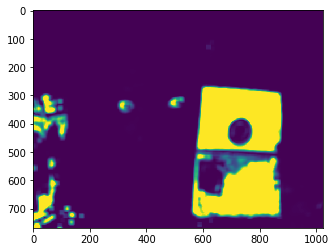

0.99887755792588


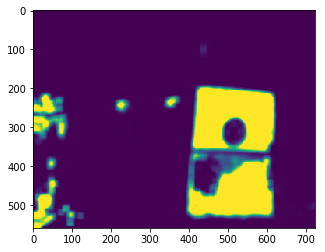

0.9966909885406494


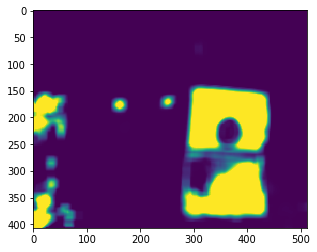

0.9895159285515547


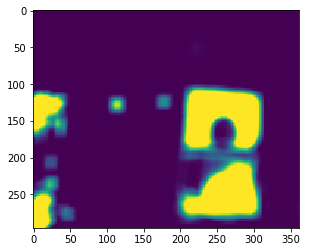

0.9969799593091011


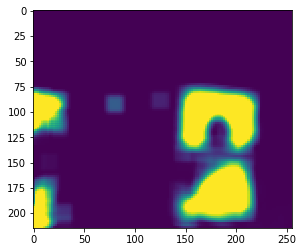

0.963094818405807


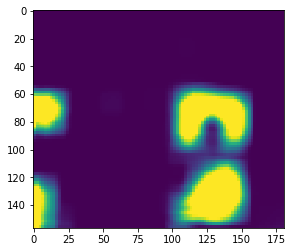

0.925271837040782


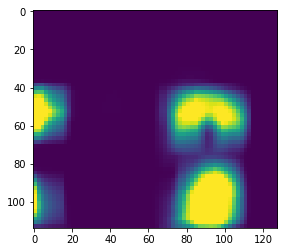

0.7863343898206949


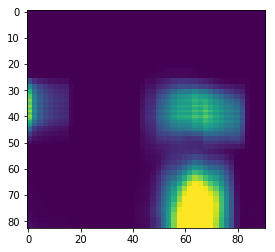

0.4512497984105721


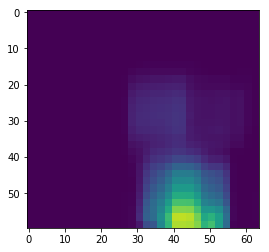

0.19517842567681024


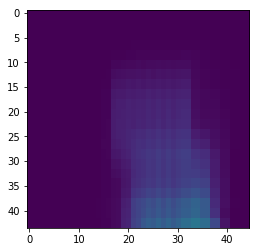

0.19522975121314326


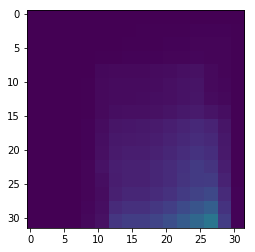

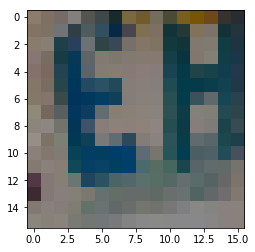

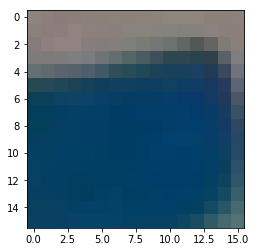

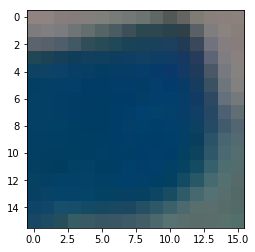

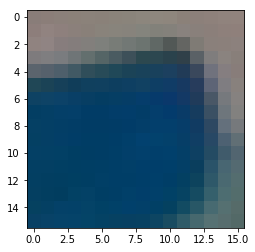

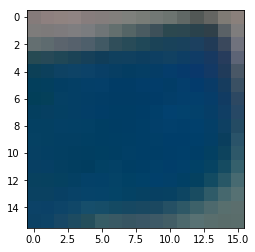

Result for 02_pass_general.pickle is 0.938 gini
0.9992279913276434


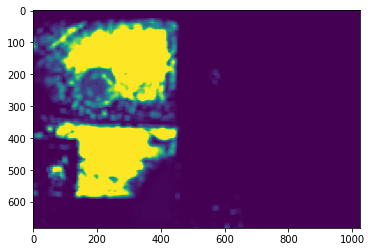

0.9990116506814957


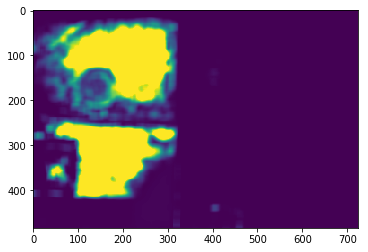

0.9991094460710883


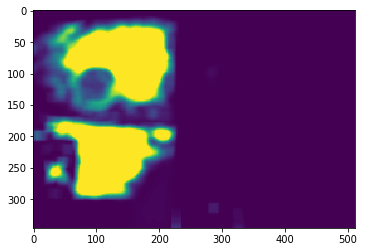

0.9980193627998233


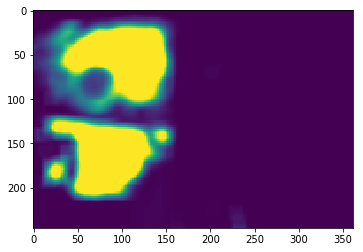

0.9972508484497666


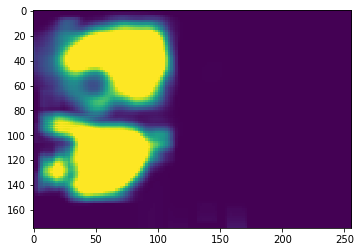

0.9936497043818235


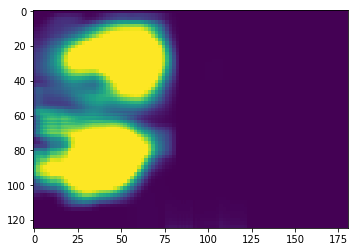

0.9871647292748094


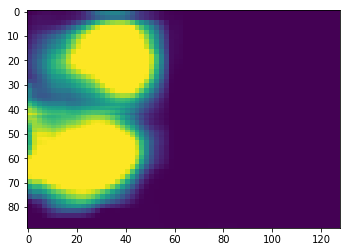

0.8954584626480937


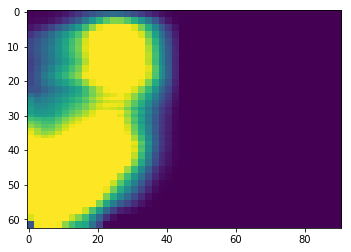

0.9615230162938436


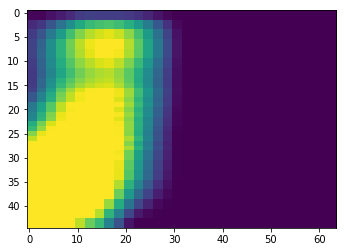

0.9565209150314331


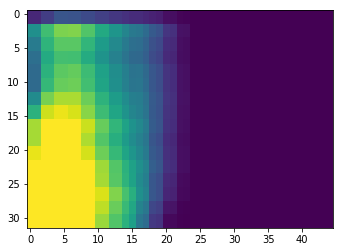

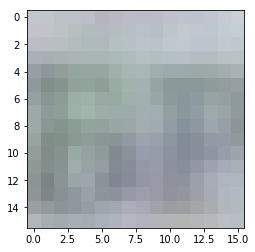

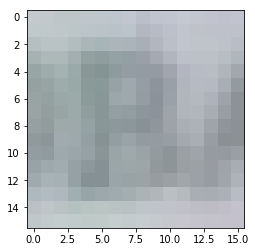

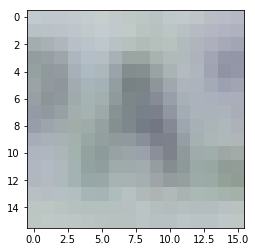

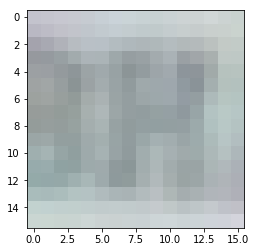

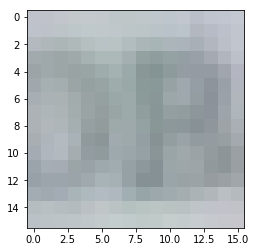

Result for 03_pass_general.pickle is 0.925 gini
0.9874192243441939


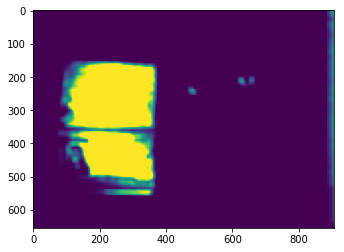

0.9853392308577895


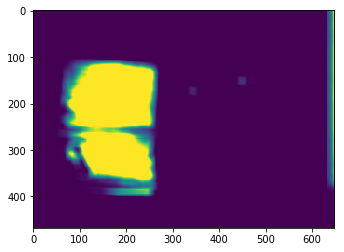

0.9810653394088149


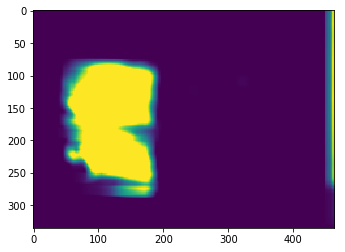

0.9692435869947076


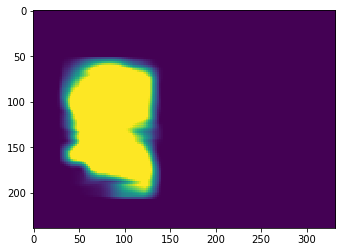

0.9499283926561475


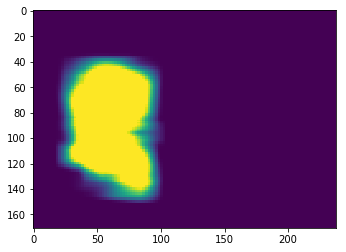

0.9410509448498487


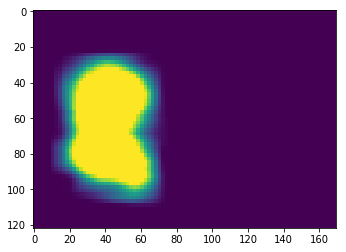

0.9233161709271371


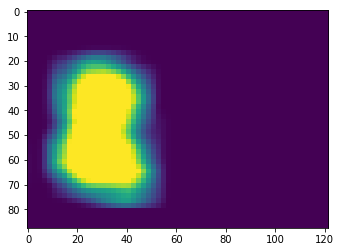

0.8594389115460217


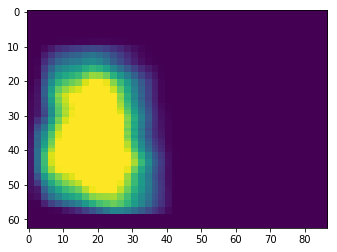

0.9162650257349014


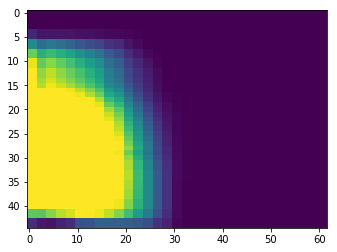

0.9805052876472473


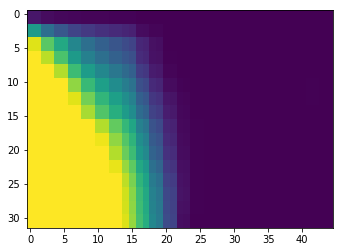

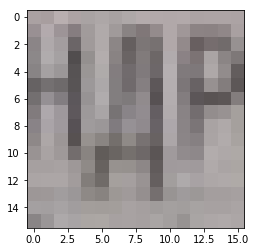

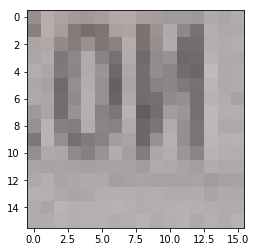

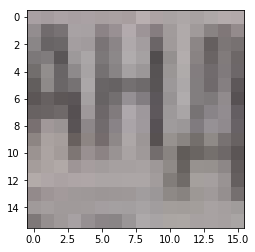

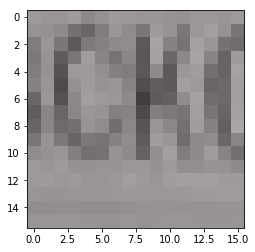

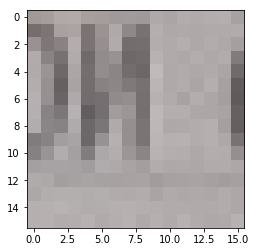

Result for 04_pass_general.pickle is 0.786 gini
0.9986967649310827


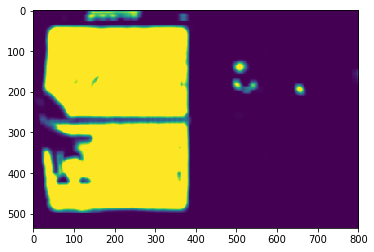

0.9984547337517142


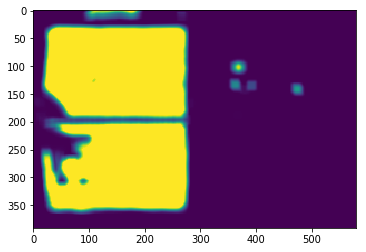

0.9965978460386395


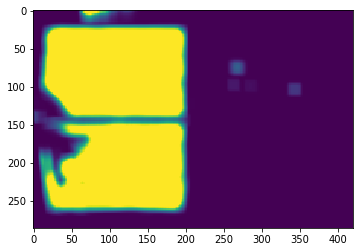

0.9952311320230365


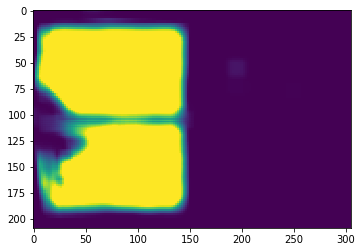

0.9950580410659313


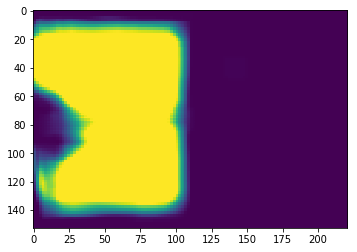

0.9904021099209785


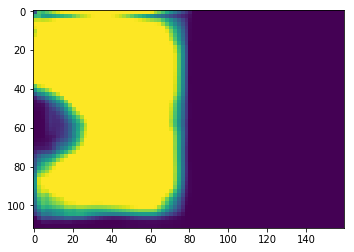

0.9841937329620123


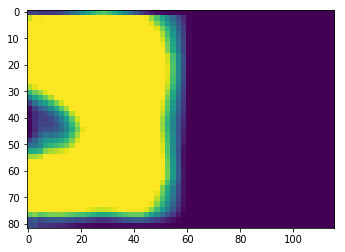

0.9829465866088867


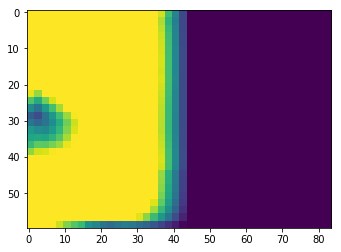

0.9918688109942845


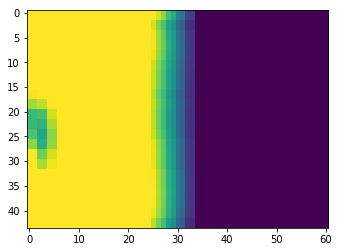

0.9513095617294312


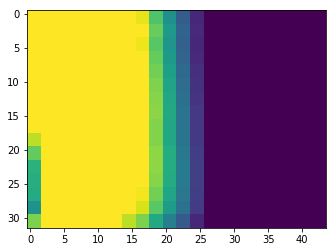

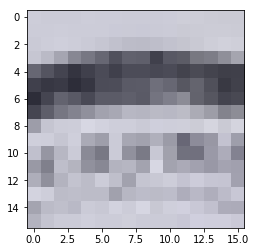

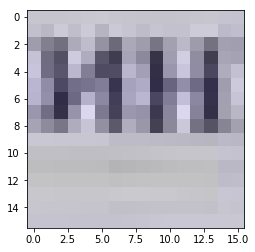

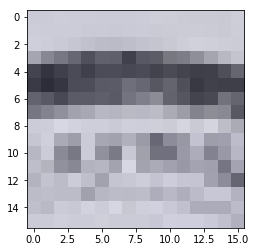

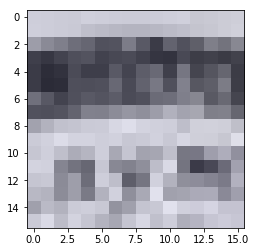

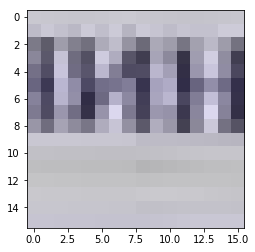

Result for 05_pass_general.pickle is 0.785 gini
0.9993464527651668


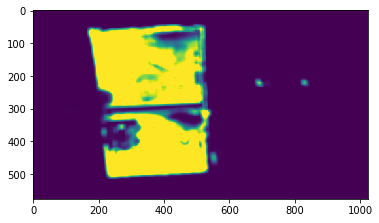

0.9994460474699736


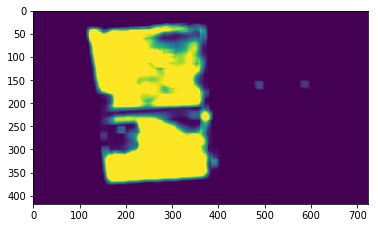

0.9985926458612084


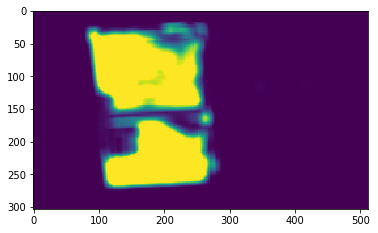

0.9966077050194144


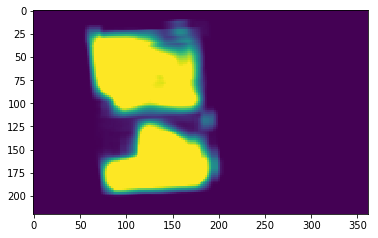

0.9948447858914733


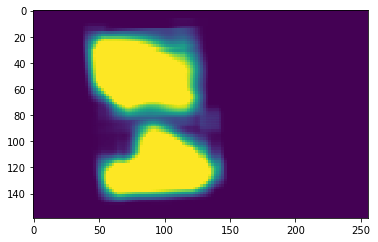

0.9853832442313433


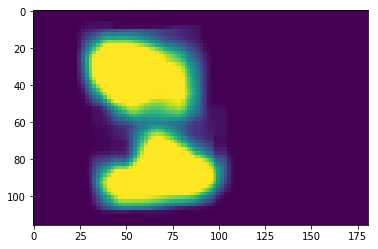

0.9283634247258306


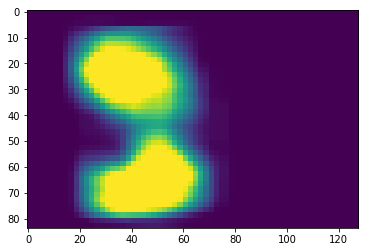

0.8708113171160221


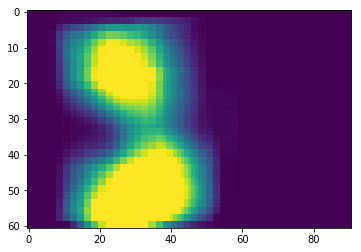

0.8455683030188084


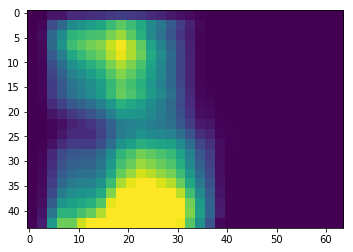

0.5148381203413009


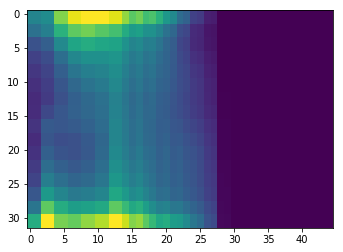

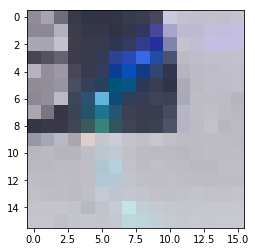

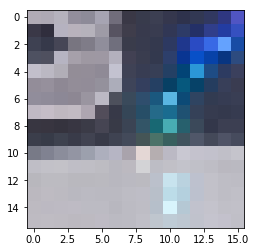

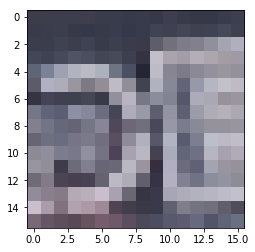

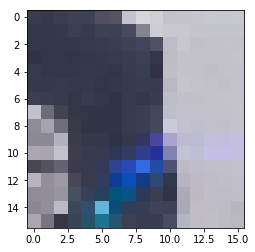

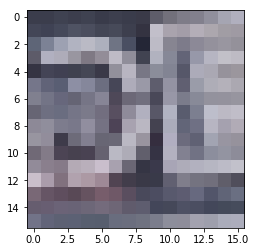

Result for 06_pass_general.pickle is 0.835 gini
0.9999962821602821


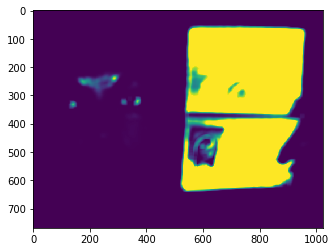

0.9999971464276314


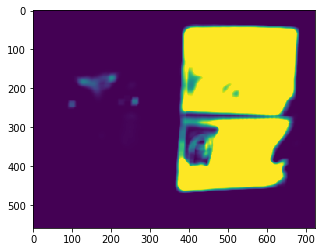

0.9999988749623299


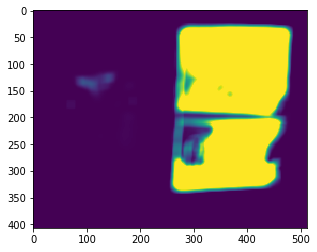

0.9999987185001373


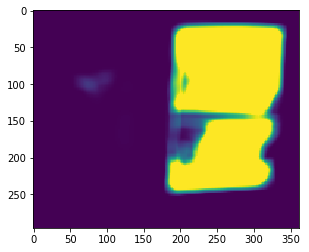

0.999998027458787


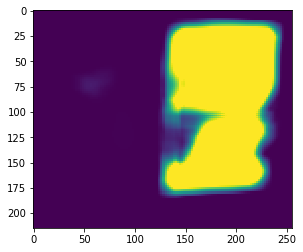

0.9999950919300318


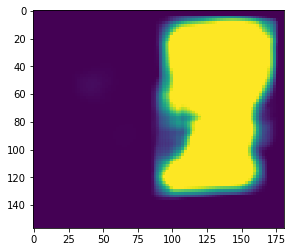

0.9999907575547695


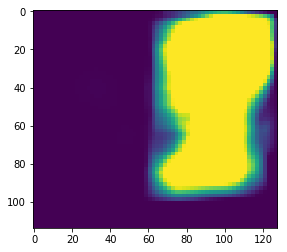

0.9998207148164511


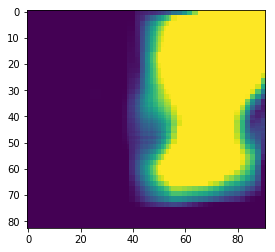

0.9953052898248037


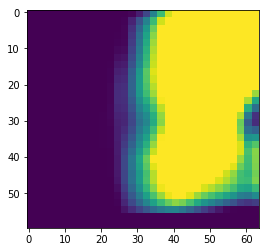

0.9971657395362854


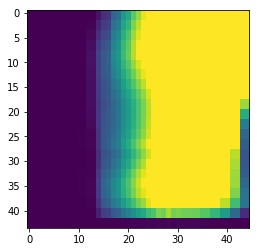

0.9744768738746643


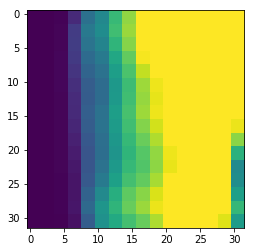

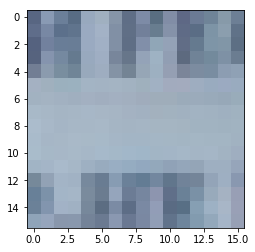

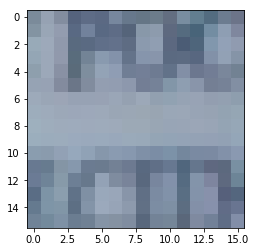

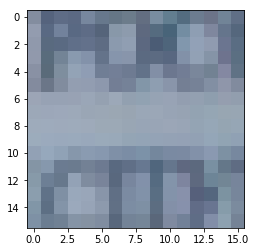

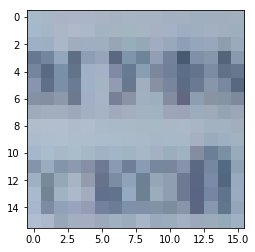

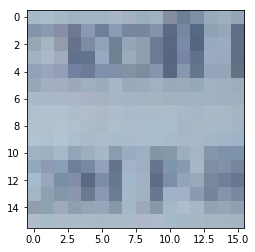

Result for 08_pass_general.pickle is -0.212 gini
0.4833594679366797


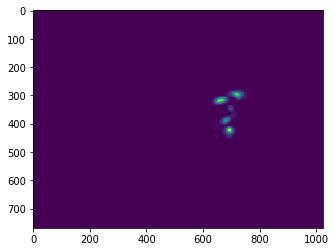

0.34674229327356443


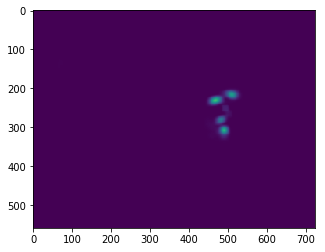

0.2400108157005434


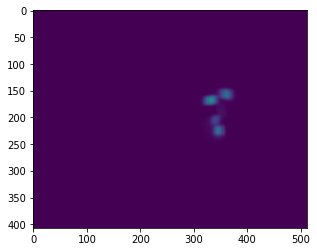

0.12692820126770243


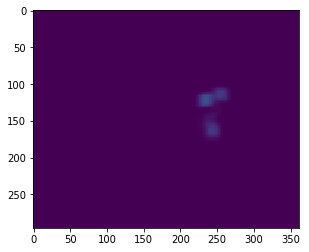

0.05972600249185689


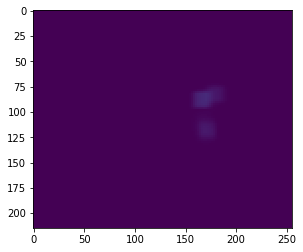

0.018331272036007817


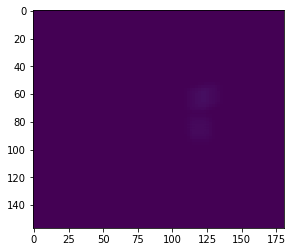

0.007473402581653299


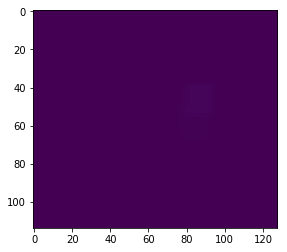

0.0013037439040861631


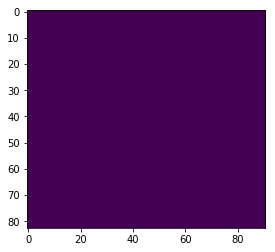

0.00032381522248634


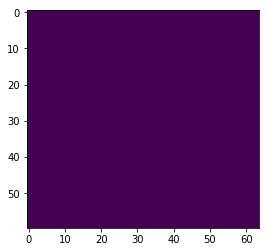

0.0005993509562877142


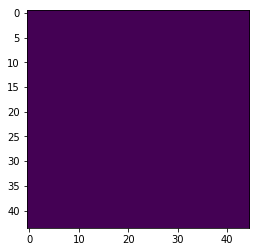

0.0005449432782774642


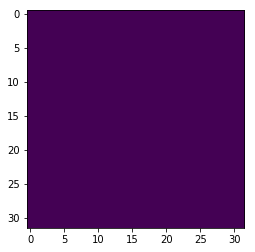

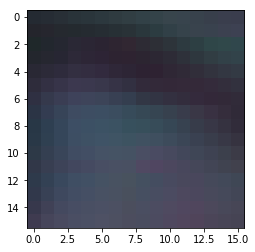

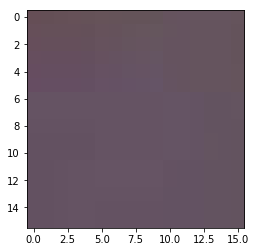

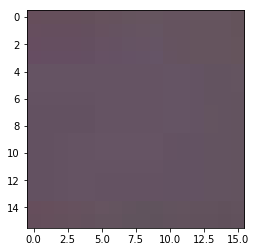

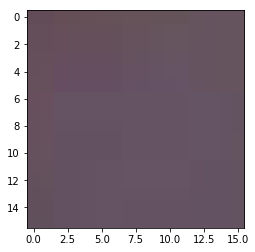

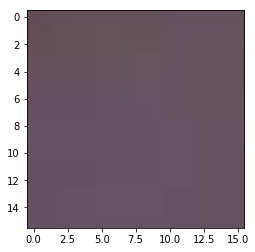

Result for 08b_pass_general.pickle is 0.788 gini
0.9999724077060819


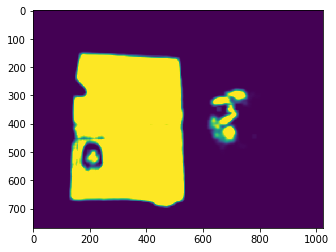

0.9996152697131038


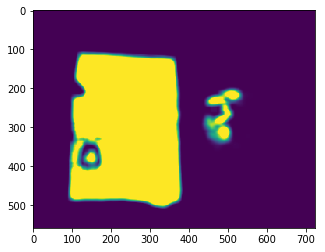

0.9981698170304298


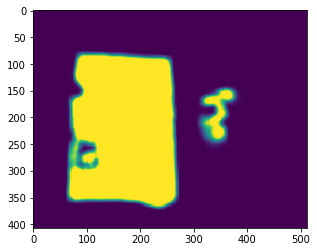

0.9977081781253219


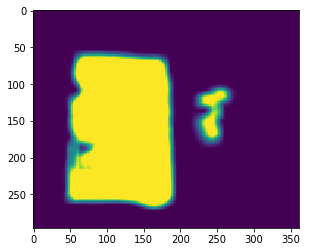

0.9969453727826476


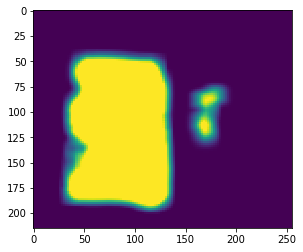

0.996176122687757


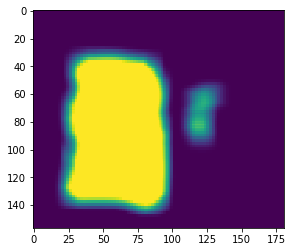

0.9903976833447814


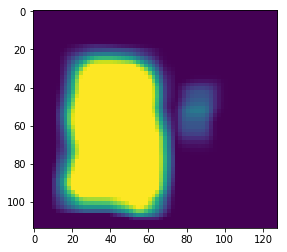

0.974728268571198


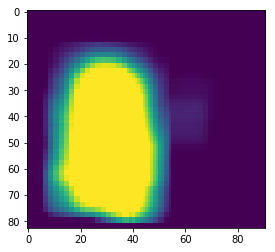

0.9576465077698231


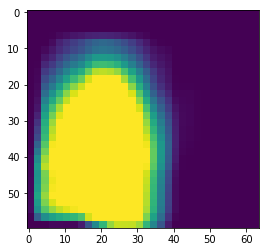

0.9395713493937538


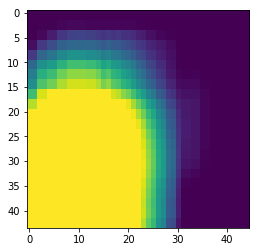

0.9401034712791443


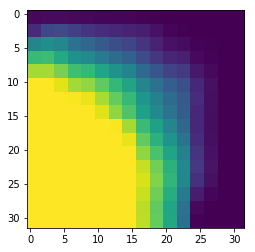

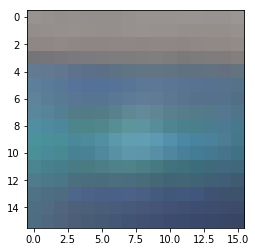

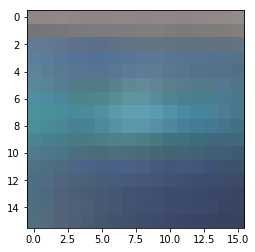

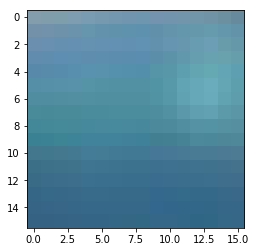

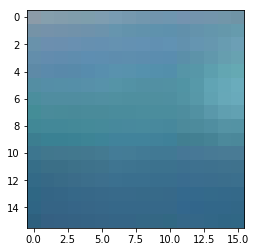

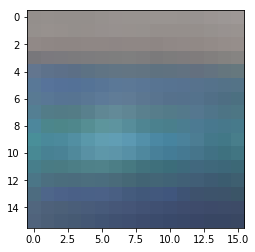

Result for test_vs_pass_general.pickle is 0.930 gini
0.9770916793495417


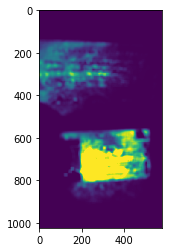

0.9832476666197181


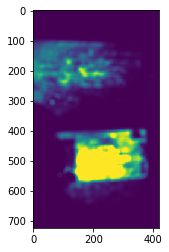

0.9675957495346665


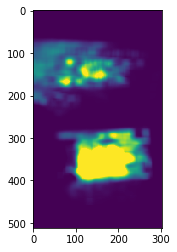

0.9674446256831288


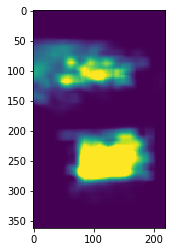

0.9608012270182371


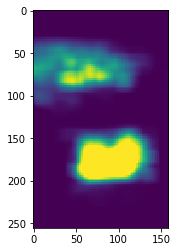

0.9256635131314397


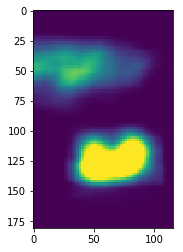

0.8865769738331437


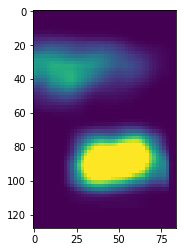

0.720394748263061


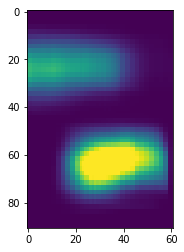

0.5408569685532711


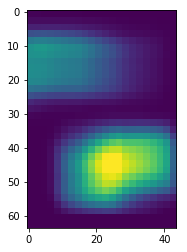

0.5397166741412548


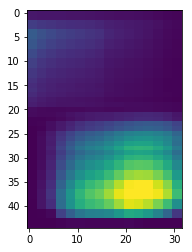

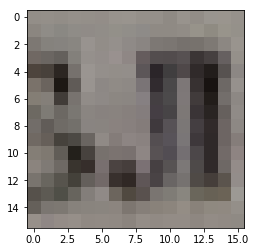

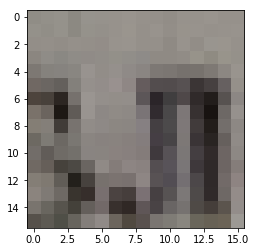

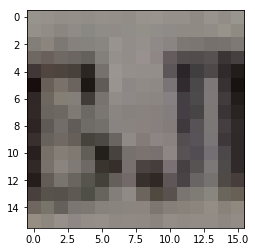

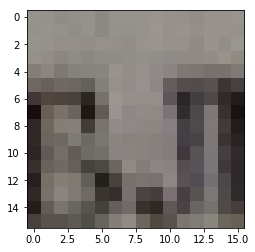

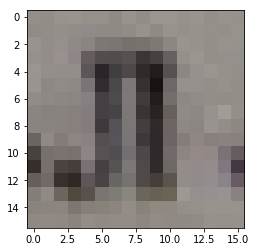

In [78]:
calc_names = ['01_pass_general.pickle', '02_pass_general.pickle',
              '03_pass_general.pickle', '04_pass_general.pickle',
              '05_pass_general.pickle', '06_pass_general.pickle',
              '08_pass_general.pickle', '08b_pass_general.pickle', 'test_vs_pass_general.pickle']
calc_batch_size = 16384
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tf_saver.restore(tfs, 'models/pass_general_v2_19')
    print('Restored')
    for fname in calc_names:
        result_p = score_file(os.path.join(path, fname), calc_batch_size,
                        lambda x: graph['p'].eval(feed_dict={graph['x']: x / 255.0 - 0.5})[:,0])
        
        with open(os.path.join(path, fname), 'rb') as f:
            sample, size_chain, img_fname = pickle.load(f)
        targets = smpl.extract_targets_from_samples(sample)
        gini = 0
        if any(targets>0.5):
            gini = sklearn.metrics.roc_auc_score((targets>0.5)*1, result_p) * 2 - 1
        pmaps = trnt.combine_value_map_2d(sample, result_p)        
        
        print('Result for {0} is {1:.3f} gini'.format(fname, gini))
        for pmap in pmaps:
            print(np.max(pmap))
            plt.imshow(pmap.transpose(), vmin=0, vmax=0.5)
            plt.show()
           
        top_ids = sorted(enumerate(result_p), key=lambda x: x[1], reverse=True)[:5]
        image = cv2.cvtColor(cv2.imread(img_fname), cv2.COLOR_BGR2RGB)
        for q in trnt.generate_batches_from_image_sample(image, [(*sample[i],p) for (i,p) in top_ids], size_chain, 16, shuffle=False):
            for z in q[0]:
                plt.imshow(z)
                plt.show()

In [55]:
[(*sample[i],p) for (i,p) in top_ids]

[(6, 70, 86, 44, 60, 0.0, 0.7038165),
 (2, 2, 18, 371, 387, 0.0, 0.68166),
 (7, 57, 73, 55, 71, 0.5295807706226854, 0.67202044)]

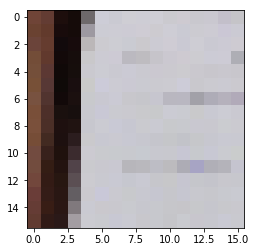

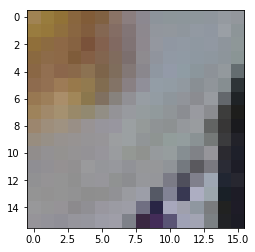

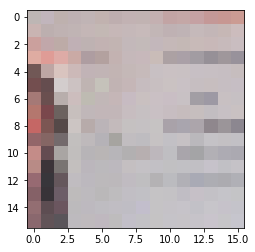